# UNSUPERVISED MACHINE LEARNING: FIFA Players Segmentation Using K-Means Clustering Method

## INTRODUCTION

FIFA Players segmentation is the process of dividing a players into smaller groups or segments based on common characteristics such as demographics, behavior, or preferences. Unsupervised machine learning algorithms such as clustering are often used for customer segmentation, as they can automatically identify patterns and similarities in large datasets without the need for labeled data.

K-Means Clustering is a popular algorithm for customer segmentation. It works by dividing the data into a predetermined number of clusters, with each cluster representing a segment of customers that share similar characteristics.

## DATA

The dataset has about `16155` rows and `110` columns. The dataset for this project can be found [here](https://drive.google.com/file/d/1p4mvc-OgskzWqk3up1pLlVMAsKVz65S5/view?usp=sharing). However, we will be interested in analyzing the following features about the FIFA players:

* **`overall:`** Overall rating
* **`potential:`** Potential rating
* **`value_eur`** Value to their current clubs
* **`wage_eur:`** Players wage
* **`age:`** Players age


## HIGHLIGHTS

1. Prepare Data
    1. Import and wrangle dataset
    2. Explore
    3. Split: No target vector

2. Build Model
    1. Iterate: K-means model, choose number of clusters.

3. Communicate Results
    1. Extract Cluster centroids
    2. Side-by-side bar chart


## Prepare Data

### Import libraries and wrangle dataset


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Setting pandas display
pd.options.display.max_columns = 1_000
pd.options.display.max_rows = 1_000


# Libraries for model
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA

In [2]:
# Define relevant functions

# Define function to load dataset
def wrangle_data(filename: str, sep = ",") -> pd.DataFrame:
    """Define a function that returns dataframe and loads into the python environment
    
    Keyword arguments:
    filename -- str, this takes in the filename and returns it as a dataframe
    sep -- str, this sets the module of the filename to default value of ","
    Return: This returns the loaded file as a pandas dataframe
    """
    data = pd.read_csv(filename, sep=sep)

    # Subset the dataframe
    data = data.copy()
    features = ['overall','potential','value_eur','wage_eur','age']
    data = data[features]

    # Get the mean values for columns with missing data
    mean_value_eur = data["value_eur"].mean()
    mean_wage_eur = data["wage_eur"].mean()

    # Fill missing values with mean values
    data["value_eur"].fillna(mean_value_eur, inplace=True)
    data["wage_eur"].fillna(mean_wage_eur, inplace=True)

    # Return result
    return data


# Define function to plot histogram
def hist_plot(data: pd.DataFrame, features: list[str]) -> 'plots':
    """Returns histogram for numerical features

    Params:
        data :pd.DataFrame, returns the loaded data
        features: list[str], returns list of features
    """
    plt.figure(figsize=(15,10))
    for i, feat in enumerate(features):
        # plt.rcParams.update({'font.size': 14})
        plt.subplot(3,2,i+1)
        axs = sns.histplot(data=data, x=data[feat])
        axs.set_title(f"Histogram for: {feat.title()}")
        axs.set_xlabel(f"{feat.title()}")
        axs.set_ylabel('Frequency')
        plt.xticks(rotation=45)

    plt.tight_layout();



# Define function to plot heatmap
def heatmap_plot(df):
    plt.figure(figsize=[15,5])
    corr = df.corr()
    sns.heatmap(corr, fmt=".2f", annot=True, cmap='rocket_r')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("Heat map for Bivariate features")


# Define function to plot kmeans cluster for the final model
def cluster_plot(data, feat1, feat2, feat3, centroids, labels):
    plt.figure(figsize=[13,8])

    # First plot
    plt.subplot(2,2,1)
    sns.scatterplot(data=data, x=f"{feat1}", y=f"{feat2}", hue=labels, palette="deep")
    plt.title(f"Scatter plot of: {feat1} Vs {feat2}")
    plt.xlabel(f"{feat1}")
    plt.ylabel(f"{feat2}")
    plt.legend()
    plt.scatter(x=centroids[:, 0],y=centroids[:, 1],color='grey',marker='*',s=150)
    plt.legend(title="Clusters")

    # Second plot
    plt.subplot(2,2,2)
    sns.scatterplot(data=data, x=f"{feat1}", y=f"{feat3}", hue=labels, palette="deep")
    plt.title(f"Scatter plot of: {feat1} Vs {feat3}")
    plt.xlabel(f"{feat1}")
    plt.ylabel(f"{feat3}")
    plt.legend()
    plt.scatter(x=centroids[:, 0],y=centroids[:, 1],color='grey',marker='*',s=150)
    plt.legend(title="Clusters")


    # Third plot
    plt.subplot(2,2,3)
    sns.scatterplot(data=data, x=f"{feat2}", y=f"{feat3}", hue=labels, palette="deep")
    plt.title(f"Scatter plot of: {feat2} Vs {feat3}")
    plt.xlabel(f"{feat2}")
    plt.ylabel(f"{feat3}")
    plt.scatter(x=centroids[:, 0],y=centroids[:, 1],color='grey',marker='*',s=150)
    plt.legend(title="Clusters")

    plt.tight_layout();


# Define function for plots of elbow method
def elbow_plot(n_cluster, silhouette_scores, inertia_errors):
    plt.figure(figsize=[10,5])

    plt.subplot(1,2,1)
    sns.lineplot(x=n_cluster, y=inertia_errors)
    plt.title("K-Means Model: Inertia vs Number of Clusters")
    plt.xlabel("No of clusters")
    plt.ylabel("inertia")

    plt.subplot(1,2,2)
    sns.lineplot(x=n_cluster, y=silhouette_scores)
    plt.title("K-Means Model: Silhouette Scores vs Number of Clusters")
    plt.xlabel("No of clusters")
    plt.ylabel("Silhouette Scores")

    plt.tight_layout();


# Define function to plot kmeans cluster for the final model
def cluster_plot_final(data, feat1, feat2, feat3, feat4, labels):
    plt.figure(figsize=[13,8])

    # First plot
    plt.subplot(2,2,1)
    sns.scatterplot(data=data, x=f"{feat1}", y=f"{feat2}", hue=labels, palette="deep")
    plt.title(f"Scatter plot of: {feat1} Vs {feat2}")
    plt.xlabel(f"{feat1}")
    plt.ylabel(f"{feat2}")
    plt.legend()
    plt.legend(title="Clusters")

    # Second plot
    plt.subplot(2,2,2)
    sns.scatterplot(data=data, x=f"{feat1}", y=f"{feat3}", hue=labels, palette="deep")
    plt.title(f"Scatter plot of: {feat1} Vs {feat3}")
    plt.xlabel(f"{feat1}")
    plt.ylabel(f"{feat3}")
    plt.legend()
    plt.legend(title="Clusters")

    # Third plot
    plt.subplot(2,2,3)
    sns.scatterplot(data=data, x=f"{feat1}", y=f"{feat4}", hue=labels, palette="deep")
    plt.title(f"Scatter plot of: {feat1} Vs {feat4}")
    plt.xlabel(f"{feat1}")
    plt.ylabel(f"{feat4}")
    plt.legend(title="Clusters")

    # Fourth plot
    plt.subplot(2,2,4)
    sns.scatterplot(data=data, x=f"{feat2}", y=f"{feat4}", hue=labels, palette="deep")
    plt.title(f"Scatter plot of: {feat2} Vs {feat4}")
    plt.xlabel(f"{feat2}")
    plt.ylabel(f"{feat4}")
    plt.legend(title="Clusters")

    plt.tight_layout();



In [3]:
df = wrangle_data("players_15.csv")
df.head()

C:\Users\IKECHUKWU\AppData\Local\Temp\ipykernel_14820\434650851.py:12: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename, sep=sep)


,overall,potential,value_eur,wage_eur,age
0,93,95,100500000.0,550000.0,27
1,92,92,79000000.0,375000.0,29
2,90,90,54500000.0,275000.0,30
3,90,90,52500000.0,275000.0,32
4,90,90,63500000.0,300000.0,28


In [4]:
df.shape

(16155, 5)

In [5]:
df.isna().sum()

overall      0
potential    0
value_eur    0
wage_eur     0
age          0
dtype: int64

In [6]:
# Checking the summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16155 entries, 0 to 16154
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   overall    16155 non-null  int64  
 1   potential  16155 non-null  int64  
 2   value_eur  16155 non-null  float64
 3   wage_eur   16155 non-null  float64
 4   age        16155 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 631.2 KB


In [7]:
# Check the statistical properties of the dataset
df.describe()

,overall,potential,value_eur,wage_eur,age
count,16155.000000,16155.000000,1.615500e+04,16155.000000,16155.000000
mean,63.830393,68.350108,1.081706e+06,13252.513194,24.776230
std,7.169896,6.580610,2.815207e+06,23433.623551,4.625321
min,40.000000,40.000000,1.000000e+03,2000.000000,16.000000
25%,59.000000,64.000000,1.300000e+05,2000.000000,21.000000
50%,64.000000,68.000000,3.750000e+05,5000.000000,24.000000
75%,68.000000,73.000000,9.250000e+05,10000.000000,28.000000
max,93.000000,95.000000,1.005000e+08,550000.000000,44.000000


### Explore Data

#### Univariate EDA

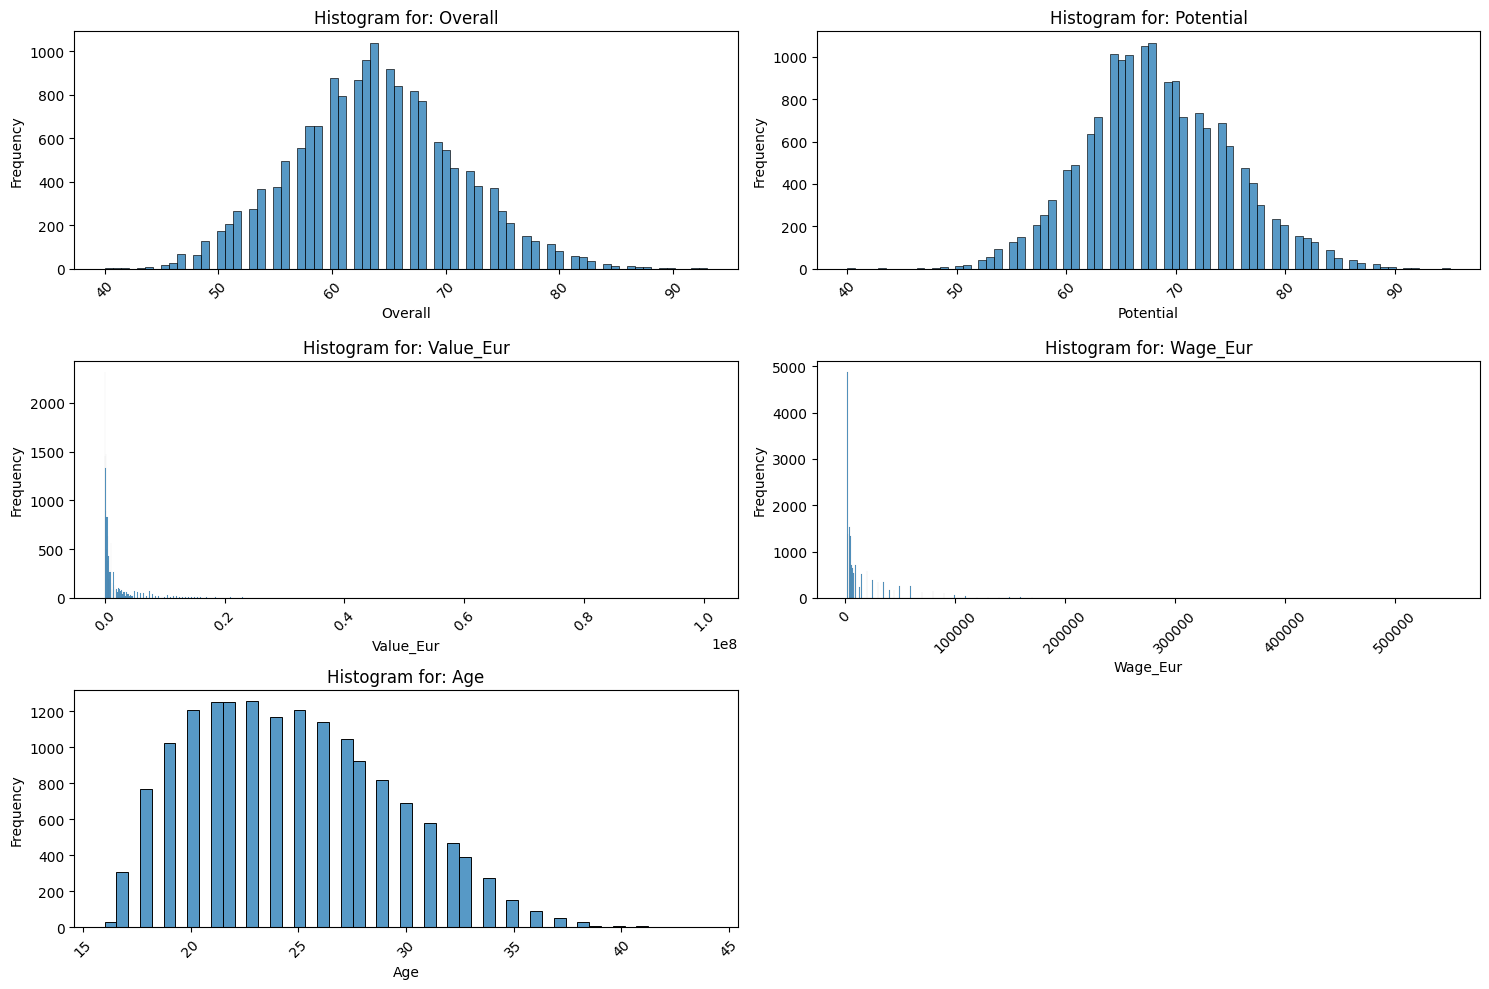

In [8]:
hist_plot(df, features=df.columns)

#### Bivariate EDA

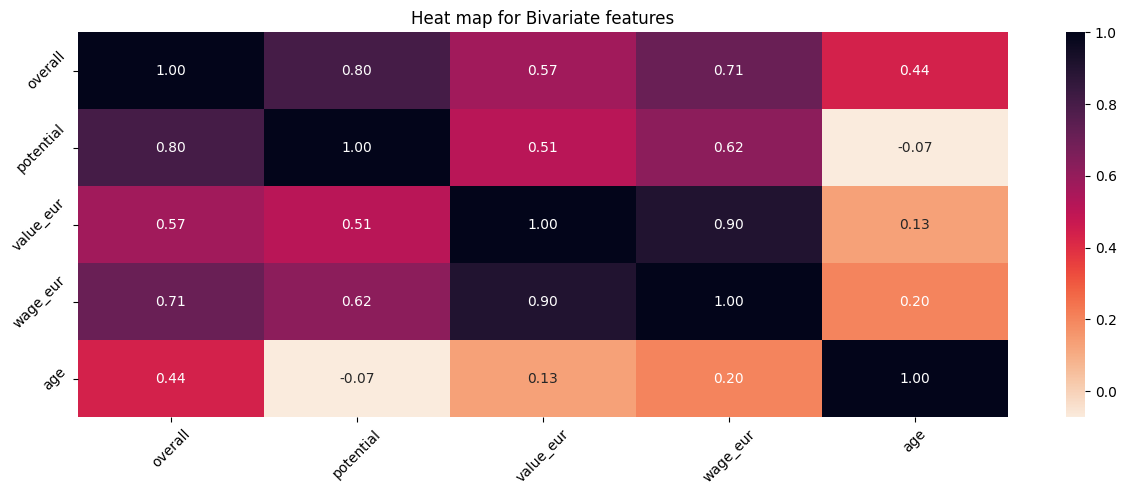

In [9]:
# Plot heatmap for bivariate
heatmap_plot(df=df)

### Split dataset

This is just renaming the dataframe to `X` feature variables as unsupervised machine learning does not have target or lable variable.

In [10]:
X = df
X.shape

(16155, 5)

## Build Model

### Iterate Model: K-Means Clustering

In this section, we'll try to train a `K-Means` model by determining the best cluster using the scores from `inertia` and `silhouette` using `elbow` method.

The steps to be used here include the following:

* Scale the dataset and pass into a data pipeline
* Initialize the cluster centroids
* Get the label of the data points
* Update the centroids
* Repeat steps 3 and 4 until the centroid is constant

In [11]:
# Determine the best cluster for the model using for-loop
n_cluster = range(2,15)
inertia_errors = []
silhouette_scores = []

# Using `for` loop to train model and calculate the inertia and silhouette score.
for k in n_cluster:
    # Instantiate model
    model = Pipeline(
        steps=[
            ("standardscaler", StandardScaler()),
            ("kmeans", KMeans(n_clusters=k, random_state=42))
        ]
    )

    # Fit model
    model.fit(X)

    # Get the inertia
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    # Get silhouette sore
    silhouette_scores.append(silhouette_score(X, model.named_steps["kmeans"].labels_))

print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [52544.79446339799, 39436.73400465066, 30645.25846005346]

Silhouette Scores: [0.7001084178883246, 0.35503644414417723, 0.17358562657042803]


In [12]:
# Store result in dataframe
metrics = {
    "inertia_errors": inertia_errors,
    "silhouette_scores":silhouette_scores
}

eval_metrics = pd.DataFrame(data=metrics)
# Rename the index column
eval_metrics.index.rename('index', inplace=True)
# Re-number the index column
eval_metrics.index +=1
eval_metrics

,inertia_errors,silhouette_scores
index,,
1,52544.794463,0.700108
2,39436.734005,0.355036
3,30645.258460,0.173586
4,23772.550727,0.103296
5,19674.468252,0.107988
6,17503.468751,0.055392
7,15616.837103,-0.002924
8,14066.724861,0.003534
9,12567.088058,-0.007860


### Using Elbow method to determine the number of clusters

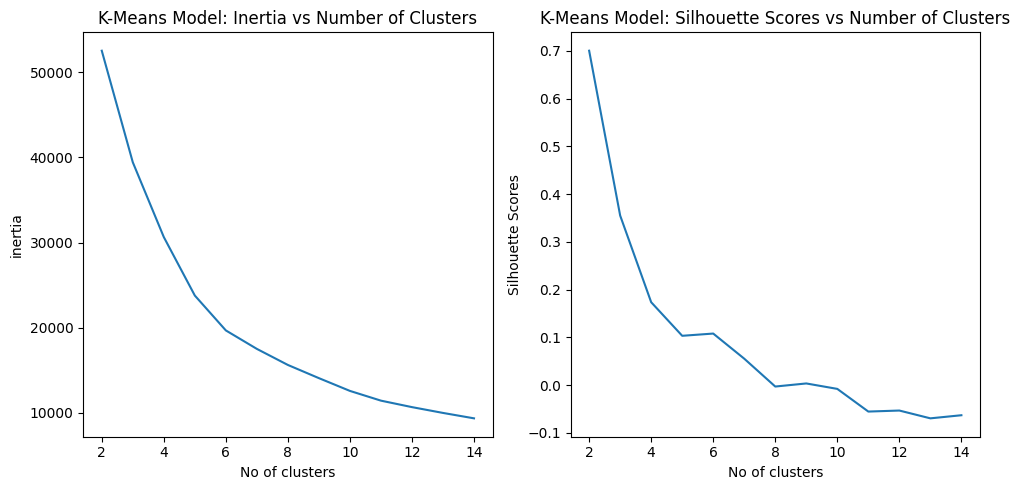

In [13]:
# Plot of elbow method to determine the number of clusters for k-means model
elbow_plot(n_cluster, silhouette_scores, inertia_errors)

**Observation**

From the result of the elbow plots using inertia errors and silhouette scores, the best scores occur at cluster 5. Hence, this will be used to fit the final model

In [14]:
# Fitting the final model
model_final = Pipeline(steps=[
            ("standardscaler", StandardScaler()),
            ("kmeans", KMeans(n_clusters=5, random_state=42))
            ]
            )

# Fit the model
model_final.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=5, random_state=42))])

In [15]:
# Getting the labels of model
labels = model_final.named_steps["kmeans"].labels_
print(labels[:5])

[2 2 2 2 2]


In [16]:
# Getting the centroids
centroids = model_final.named_steps["kmeans"].cluster_centers_
print(centroids)

[[ 0.12983132 -0.46736655 -0.19229164 -0.2387429   1.08779454]
 [ 0.2214553   0.6147336  -0.14173286 -0.19926835 -0.53750045]
 [ 2.81015114  2.60400306  7.73443795  6.4248064   0.47766318]
 [-1.12130539 -0.82915023 -0.34437546 -0.46135767 -0.77396876]
 [ 1.5900829   1.39822851  1.09600484  1.72949443  0.46789882]]


## Communicate Result

Reduce the dimensionality of the dataset into two by using the `PCA` transformer


In [17]:
# Instantiate the PCA class
pca = PCA(n_components=2, random_state=42)

# Fit and transform the dataset
X_tr = pca.fit_transform(X, )

# Put the transformed data into a frame
X_pca = pd.DataFrame(X_tr, columns=["PC1","PC2"])

# Investigate the dataframe
X_pca.head()


,PC1,PC2
0,9.941952e+07,211412.694512
1,7.791881e+07,224615.404002
2,5.341875e+07,140244.570993
3,5.141881e+07,125194.122328
4,6.241868e+07,182972.299384


In [18]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    data_frame=X_pca,
    x='PC1',
    y='PC2',
    color=labels.astype(str),
    title="PCA Representation of Clusters"
)
fig.update_layout(xaxis_title="PC1",yaxis_title="PC2")


fig.show()

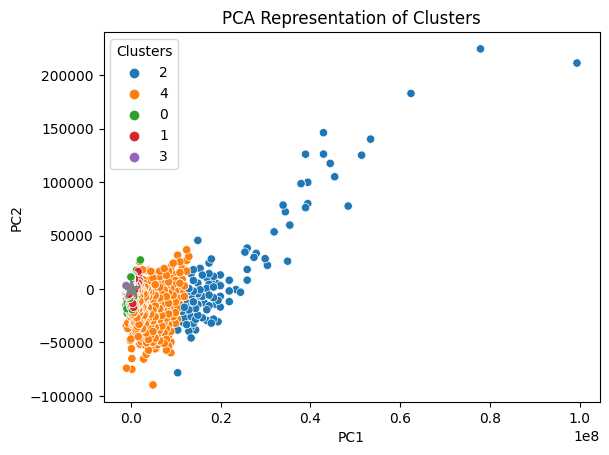

In [20]:
# Plot using seaborn
sns.scatterplot(data=X_pca, x="PC1", y="PC2", hue=labels.astype(str))
plt.scatter(x=centroids[:, 0],y=centroids[:, 1],color='grey',marker='*',s=150)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Representation of Clusters")
plt.legend(title="Clusters");

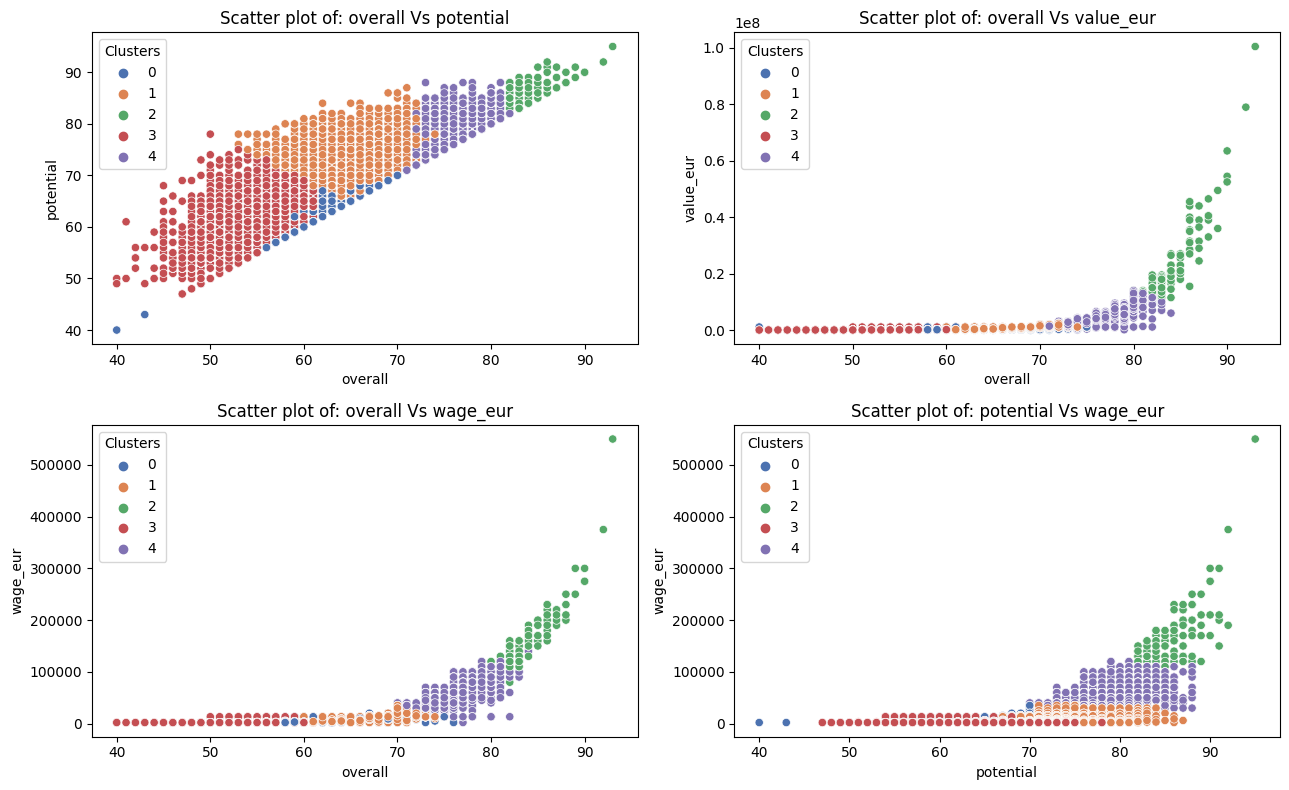

In [21]:
# Getting the final cluster for the features
cluster_plot_final(data=df, feat1="overall", feat2="potential",
                   feat3="value_eur", feat4="wage_eur", labels=labels)

**Investigating the categories of players in various clusters**

In [22]:
# Loading the original dataset
df2 = pd.read_csv("players_15.csv")

C:\Users\IKECHUKWU\AppData\Local\Temp\ipykernel_14820\1727481097.py:2: DtypeWarning:

Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.



In [23]:
# Investigate players in cluster 2
features = ['overall','potential','value_eur','wage_eur','age']

# Checking the details of the best 5 players from cluster 2
top_5_cluster_2 = (df2[labels==2][["short_name"]+features].
                     sort_values("wage_eur",ascending=False)[:5])# Add to dataframe
top_5_players = pd.DataFrame(data=top_5_cluster_2)
top_5_players

,short_name,overall,potential,value_eur,wage_eur,age
0,L. Messi,93,95,100500000.0,550000.0,27
1,Cristiano Ronaldo,92,92,79000000.0,375000.0,29
4,M. Neuer,90,90,63500000.0,300000.0,28
6,L. Suárez,89,91,49500000.0,300000.0,27
2,A. Robben,90,90,54500000.0,275000.0,30


In [24]:
# Investigate players in cluster 4
# Checking the details of the best 5 players from cluster 0
top_5_cluster_4 = (df2[labels==4][["short_name"]+features].
                     sort_values("wage_eur",ascending=False)[:5])
# Add to dataframe
top_5_players_4 = pd.DataFrame(data=top_5_cluster_4)
top_5_players_4

,short_name,overall,potential,value_eur,wage_eur,age
46,A. Pirlo,84,84,6000000.0,140000.0,35
73,Dani Alves,83,83,10000000.0,140000.0,31
106,T. Motta,82,82,9500000.0,130000.0,31
68,Pepe,83,83,10000000.0,130000.0,31
70,N. Vidić,83,83,9000000.0,130000.0,32


In [25]:
# Investigate players in cluster 0 and 1
# Checking the details of the best 5 players from cluster 0
mask1 = labels == 0
mask2 = labels == 1
top_5_cluster_0_1 = (df2[mask1 | mask2][["short_name"]+features].
                     sort_values("wage_eur",ascending=False)[:5])
# Add to dataframe
top_5_players_0_1 = pd.DataFrame(data=top_5_cluster_0_1)
top_5_players_0_1

,short_name,overall,potential,value_eur,wage_eur,age
2938,J. Beausejour,70,70,1100000.0,35000.0,30
3115,H. Bernardello,70,70,1400000.0,35000.0,27
2368,L. Wilkshire,71,71,925000.0,35000.0,32
3261,O. Hawsawi,70,70,1400000.0,35000.0,28
3045,N. Sánchez,70,70,1400000.0,35000.0,28


In [26]:
# Investigate players in cluster 3
# Checking the details of the best 5 players from cluster 3
top_5_cluster_3 = (df2[labels == 3][["short_name"]+features].
                     sort_values("wage_eur",ascending=False)[:5])
# Add to dataframe
top_5_players_3 = pd.DataFrame(data=top_5_cluster_3)
top_5_players_3

,short_name,overall,potential,value_eur,wage_eur,age
9216,G. Díaz,63,65,375000.0,7000.0,24
9736,Yun Ju Tae,62,65,375000.0,7000.0,24
10447,Samuel Saiz,61,65,230000.0,7000.0,23
9760,Shin Young Jun,62,65,375000.0,7000.0,24
10595,C. Hoffman,61,65,230000.0,7000.0,23


### Conclusion:

The following describes the categories of players based on the clusters as given from the analysis:

* `Superstars`: Players that fall into this category are in cluster `2`. These are the highest-rated players who have the most impact on the team's success. They are typically the most skilled and talented players who can change the outcome of a game with their individual brilliance. Superstars are often the highest-paid players in the team. Some of the `Superstars` include `L. Messi`, `Cristiano Ronaldo`.

* `Key Players`: These are players that fall into cluster `4`. These are players who are important to the team's success, but may not be as skilled or talented as the superstars. They are usually consistent performers who play a critical role in the team's strategy and game plan. They are the second category of players that earn more after the `Superstars`. Some of the players that fall in this category include `A. Pirlo`, and `Dani Alves`.

* `Role Players`: These are players who are not as important to the team's success as the superstars or key players, but still play a vital role in the team's overall performance. They may be defenders, midfielders or forwards who play a specific role in the team's tactics and strategy. These players fall into cluster or category `0 and 1`. Some of the players in this category are `J. Beausejour`, `H. Bernardello`.

* `Squad Players`: These are players who may not be as important to the team's success as the other categories, but are still an important part of the squad. They may be used as backup players or substitutes and play a key role in maintaining team morale and spirit. They are the least `rated` and `paid` players. They fall into category or cluster `3`. Some of the players into this category are `J. Beausejour` and `H. Bernardello`.


